In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [69]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 16})

In [146]:
import os
import psycopg2 as pg

conn = pg.connect(
    host=os.getenv('DATA_HOST'), 
    port=os.getenv('DATA_PORT'), 
    database=os.getenv('DATA_DB_NAME'), 
    user=os.getenv('DATA_DB_USER'), 
    password=os.getenv('DATA_DB_PASS'),
)

# Reading data from CSV
# df = pd.read_csv('realestate.csv')
# From a database
df = pd.read_sql('SELECT * from realestate', conn)

So, this is not a comprehensive explanation of these tools, but rather a quick overview of some simple samples which allow you to leverage some basic functionalities & explore the data.

Loading data can be done from multiple sources. I used my database for the raw scraped data, on which I'm doing the analysis.

In [71]:
# Use only if needed
# df.drop('source_website', 1, inplace=True)

In [72]:
df.shape

(12956, 19)

In [147]:
df.head(3)

,fingerprint,title,description,posted_date,price,currency,partitioning,surface,building_year,floor,number_of_rooms,terrace,parking,cellar,source_website,source_offer,neighborhood,link,scraped_date
0,caf2cb8bd15af9f099a8d239a42a5d06e68c627a,Închiriez ap untold,Apartament nou la prima închiriere!Preferabil ...,2019-08-08 10:36:50.866588,100,EUR,None,100.0,dupa 2000,3.0,3.0,True,True,False,olx,proprietar,zorilor,https://www.olx.ro/oferta/inchiriez-ap-untold-...,NaT
1,e2a562c75c75ce2247e378cb79992220e4cd6cbb,Apartament 2 camere de închiriat Mărăşti,"Închiriez apartament cu 2 camere decomandate, ...",2019-05-15 22:40:00.000000,380,EUR,decomandat,56.0,1977 – 1990,4.0,2.0,True,True,False,olx,proprietar,marasti,https://www.olx.ro/oferta/apartament-2-camere-...,NaT
2,725491de74c31f07921237913d5b8117fd758216,Persoana fizica inchiriez garsoniera,Persoana fizica inchiriez garsoniera confort 1...,2019-05-16 09:15:00.000000,250,EUR,decomandat,28.0,1977 – 1990,4.0,NaN,False,False,False,olx,proprietar,manastur,https://www.olx.ro/oferta/persoana-fizica-inch...,NaT


Take a look at the data, get a feel of the fields you are working with. Shape gives you the number of rows and column, and head gives you the first 5 items in the dataset, so a small preview.

In [74]:
df['title'] = df['title'].str.lower()

# Some description were badly scraped and contain css formatting
# This corrects that
mask = df.description.str.contains('css', case=False)
df.loc[mask, 'description'] = df.loc[mask, 'description'].apply(lambda p: (p.split('}')[9]).split('.css-1prr4ql')[0])

df['description'] = df['description'].str.lower()

In [75]:
# Uneeded for analysis
unneeded_fields = ['fingerprint', 'link', 'scraped_date']

for field in unneeded_fields:
    df.drop(field, 1, inplace=True)
#     df = df.drop(field, 1)

In [76]:
# More unneeded observations (skip this if analysing these fields)
df.drop('building_year', 1, inplace=True)
df.drop('partitioning', 1, inplace=True)

In [77]:
# Updating column name
df.rename(columns={'number_of_rooms': 'rooms'}, inplace=True)

You might have uneeded obervations, that can be safely removed. Like I previously said, these fields make sense to other processes, not so much when you're doing data analysis. You have 2 ways of doing operations on dataframes, exemplified with drop: perform the action, and reasign to another variable (or itself), or use the inplace=True argument. Also, I renamed a column for ease of use.

In [78]:
# Dropping rows that don't have a posting date
df = df.dropna(subset=['posted_date'])

In [79]:
# Nullify missing values for easy replacing
df.source_offer = df.source_offer.replace({
    '': None
})

In [80]:
df['source_offer'].isna().sum()

2173

In [81]:
df['source_offer'] = df['source_offer'].fillna('unknown')

When handling rows with missing data, it's not generally recommended to just drop data, but to actually flag it as missing, but since we're relying on the posting date (we can't say for sure where in time this apartment was added), we need to eliminate ads that don't have one.
Conversely, for other fields we can go that route. For example the source of an offer has quite a sizable amount of nulls. Let's mark them as unknow.

In [82]:
df.groupby('currency').size()

currency
EUR    12635
RON      209
dtype: int64

In [83]:
# Date adjustments
df['posted_date_month'] = df['posted_date'].dt.strftime('%m')
df['posted_date_year'] = df['posted_date'].dt.strftime('%Y')
df['posted_date_day'] = df['posted_date'].dt.strftime('%d')
df['posted_date_month'] = pd.to_numeric(df['posted_date_month'], errors='coerce')
df['posted_date_year'] = pd.to_numeric(df['posted_date_year'], errors='coerce')
df['posted_date_day'] = pd.to_numeric(df['posted_date_day'], errors='coerce')

In [84]:
# Remove more than 6 months ago
df = df.loc[df.posted_date_month > 3]
df = df.loc[df.posted_date_month < 10]
df = df.loc[df.posted_date_year == 2019]

In [125]:
sort_df = df.sort_values(by='posted_date')
print(sort_df.head(1)['posted_date'])
print(sort_df.tail(1)['posted_date'])

3754   2019-04-02 09:22:00
Name: posted_date, dtype: datetime64[ns]
6969   2019-09-30 18:09:00
Name: posted_date, dtype: datetime64[ns]


In [86]:
# Average currency value from the earliest to the latest result
avg_eur_to_ron = 4.732

# Apply the conversion only to rows with RON currency
mask = df['currency'] == 'RON'
df.loc[mask, 'price'] = df.loc[mask, 'price'].apply(
    lambda p: p / avg_eur_to_ron
)

# Currency is all the same now, so it's an irrelevant observation
df.drop('currency', 1, inplace=True)

It appears we have 2 currencies! But EUR is still used in the majority of the ads, so I'm going to convert them all to EUR. I'm taking a peek at the earliset ad & the latest one and getting an average conversion, then I'm performing it in place. Now that we have only 1 currency, we can drop the currency field.

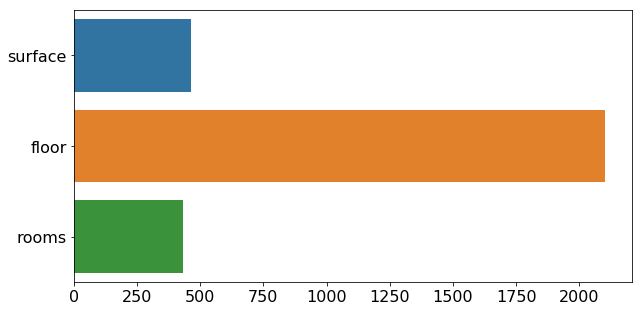

In [87]:
# Number of null values per column
df_nulls = df.isnull().sum()
df_nulls = df_nulls[df_nulls > 0]
nulls_graph = sb.barplot(x=df_nulls.values, y=df_nulls.index)

In [88]:
pd.DataFrame(df.groupby('source_offer').size(), columns=['count'])

,count
source_offer,
Agentie,33
Proprietar,33
agentie,5010
agentie imobiliara,1306
companie,361
constructor,4
persoana fizica,599
persoană fizică,22
proprietar,3025


In [89]:
df['source_offer'] = df['source_offer'].str.lower()
df.source_offer = df.source_offer.replace({
    'agentie': 'real estate agency',
    'companie': 'real estate agency',
    'constructor': 'building company',
    'persoana fizica': 'owner',
    'persoană fizică': 'owner',
    'proprietar': 'owner',
    'agentie imobiliara': 'real estate agency'
})

In [90]:
pd.DataFrame(df.groupby('source_offer').size(), columns=['count'])

,count
source_offer,
building company,4
owner,3679
real estate agency,6710
unknown,2173


Next, would be uniformization. The capitalization might be incosistent or 2 things that actually mean the same thing are expressed differently (both of which happen above). Sometimes there might be typos. For this a mapping can be provided to replace the values. Running it again, and it looks way better!

In [91]:
df.groupby('neighborhood').size()

neighborhood
? string:18 ?             1
andrei muresanu         279
aurel vlaicu              3
baciu                    67
becas                     1
borhanci                 54
bulgaria                 15
buna ziua               664
calea turzii            186
campului                 27
central                  90
centru                  971
dambul rotund            46
dorobantilor            159
est                       1
europa                  143
expo transilvania        19
faget                     2
floresti                157
gara                    831
gheorgheni              920
grigorescu              371
gruia                    52
hasdeu                   33
horea                    80
interservisan            36
intre lacuri            180
iris                    153
iulius                  640
manastur               1150
marasti                1129
muzeului                 17
not found              1666
p-ta mihai viteazul      20
piata unirii             47
plopilo

In [92]:
# Particular uniformization needed for Cluj-Napoca 
# (and done to my personal opinion)
# Might be skipped, altered or removed entirely
mapping = {
    'calea turzii': 'andrei muresanu',
    'sigma': 'zorilor',
    'cipariu':'centru',
    'motilor':'centru', 
    'muzeului':'centru', 
    'piata unirii':'centru', 
    'viteazu': 'centru', 
    'ultracentral': 'centru',
    'the office': 'marasti',
    'usamv': 'manastur',
    'polus': 'vivo',
    'interservisan': 'gheorgheni', 
    'titulescu': 'gheorgheni', 
    'iulius': 'gheorgheni',
    'expo transilvania':'intre lacuri',
    'semicentral': 'centru',
    'aurel vlaicu': 'marasti',
    'dorobantilor': 'marasti',
    'central': 'centru',
    'vest': 'floresti',
    'est': 'someseni',
    'campului': 'manastur',
    'gara': 'centru',
    'horea': 'centru',
    'hasdeu': 'centru',
    'p-ta mihai viteazul': 'centru',
    'vivo': 'floresti',
}
df.neighborhood = df.neighborhood.replace(mapping)
df = df.loc[df.neighborhood != '? string:18 ?']

In [93]:
df['price_sqm'] = df['price'] / df['surface']

New fields can also be added. For example, I wanted the price per sqm to be a column as well.

In [94]:
# Another particular usecase
# Can be skipped, especially if you handle the floor as a string
# (which is something I should have done)
df.floor = df.floor.astype(str)
df.floor = df.floor.map(lambda d: str(d).split('.')[0])
df.floor = df.floor.replace({'99': 'attic', '0': 'ground floor', '-1': 'basement'})

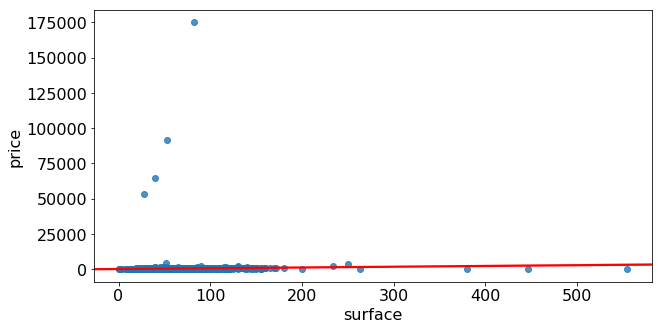

In [95]:
# Exploring the linear relationship between price and surface
def lin_graph(dataframe, x, y):
    kwargs = {'line_kws': {'color':'red'}}
    return sb.regplot(x=x, y=y, data=dataframe, **kwargs)

g = lin_graph(df, "surface", "price")

Then, we should identify outliers. I'm going to explore some linear relations to identify them. 
There are definitely outliers. Let's check them out.
These can be brought on by sellers wrongly marking apartments for sale as for rent
or other types of ads such as renting per night, dorms, office spaces, 
which are not residential and skew the results. Also people only renting out 1 rooms from 4.
After some additional cleaning, the graph looks like this

In [96]:
df.loc[df.price > 25000]

,title,description,posted_date,price,surface,floor,rooms,terrace,parking,cellar,source_website,source_offer,neighborhood,posted_date_month,posted_date_year,posted_date_day,price_sqm
6918,"apartament 3 camere, centru, ultracentral, zon...",residence imobiliare va ofera spre vanzare un ...,2019-08-30 22:05:40.352533,175000.0,82.0,1,3.0,False,False,False,storia,unknown,centru,8,2019,30,2134.146341
7490,"apartament 2 camere, centru/gara","apartament 2 camere in zona centrala, demisol,...",2019-09-08 20:00:22.352064,65000.0,40.0,basement,2.0,False,False,True,storia,owner,centru,9,2019,8,1625.000000
9047,"2 camere, finisat, mobilat ,in bloc nou, 53 mp...",local imobiliare ofera spre inchiriere un apar...,2019-09-11 20:00:41.937313,91900.0,53.0,7,2.0,True,False,False,storia,real estate agency,not found,9,2019,11,1733.962264
10816,"vanzare garsoniera confort 1, zona casa pirati...",descriere anuntcapital imobiliare va propune s...,2019-08-07 19:08:59.911536,53000.0,28.0,nan,1.0,True,False,False,storia,real estate agency,manastur,8,2019,7,1892.857143


In [97]:
# Outliers can be brought on by sellers 
# wrongly marking apartments for sale as for rent
# Or just general mislabeling and  extreme values
df = df.loc[df.price > 100]
df = df.loc[df.price < 2000]
df = df.loc[df.surface < 200]
df = df.loc[df.surface > 15]
df = df.loc[df.price_sqm < 25]

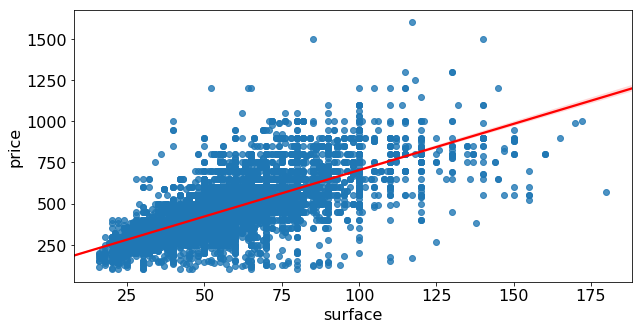

In [98]:
g = lin_graph(df, "surface", "price")

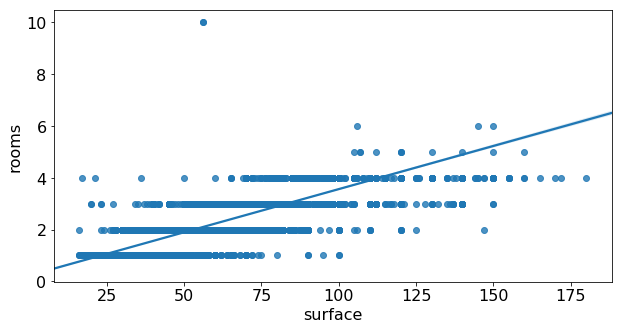

In [99]:
# Exploring the linear relationship between surface and rooms
linear_graph = sb.regplot(x="surface", y="rooms", data=df)

In [100]:
df = df.loc[df.rooms < 6]

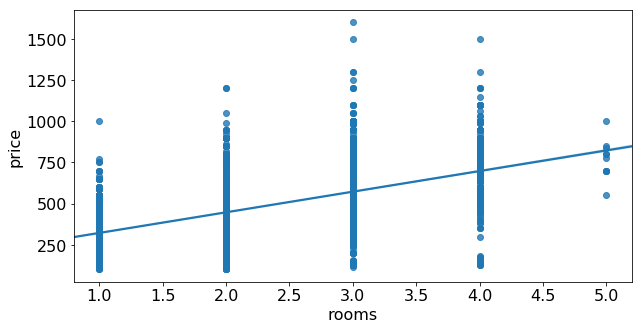

In [101]:
# Exploring the linear relationship between price and rooms
linear_graph = sb.regplot(x="rooms", y="price", data=df)

In [102]:
# Deleting office spaces, dorm, single rooms offerings
# since I'm only interested in full residential rooms
df = df.loc[df.title.str.contains('camera', case=False) == False]
df = df.loc[df.title.str.contains('camin', case=False) == False]
df = df.loc[df.title.str.contains(' ron', case=False) == False]
df = df.loc[df.title.str.contains('caut', case=False) == False]
df = df.loc[df.title.str.contains('birou', case=False) == False]

In [103]:
# Remove less than 10, not very helpful for statistics
df = df.groupby('neighborhood').filter(lambda x: len(x)>9)

In [104]:
# Writing data to CSV
df.to_csv('cleaned_data.csv', index=False)

Now that our data is cleaned, we can save it to a csv and we can start getting some stats out of it!

In [105]:
plt.rcParams.update({'font.size': 18})

In [106]:
# Some quick averages
cols = ["average price", "average price/sqm", "average surface"]

def averages(data, avg_fields):
    return pd.DataFrame([[df[field].mean() for field in avg_fields]], index=["value"], columns=cols)

averages(df, ['price', 'price_sqm', 'surface'])

,average price,average price/sqm,average surface
value,479.289716,8.352742,59.371571


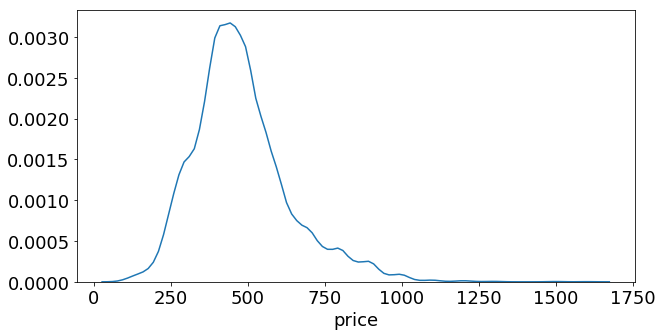

In [107]:
# Let's check out the price distribution
price_distrib_plot = sb.distplot(df["price"], hist=False);

In [129]:
# Monthly average
df_avg_month_grouped = df.groupby('posted_date_month').mean()['price']
pd.DataFrame(df_avg_month_grouped)

,price
posted_date_month,
4,435.550396
5,427.494703
6,458.311648
7,482.474896
8,474.802363
9,491.977656


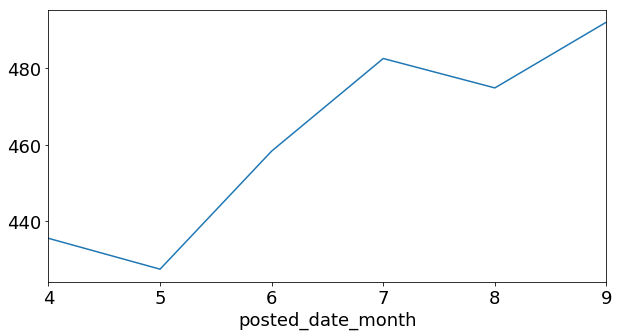

In [130]:
avg_price_month_plot = df_avg_month_grouped.plot()

In [143]:
# Average prices for top 5 most expensive
df_known_area = df[df.neighborhood != 'not found']
pd.DataFrame(df_known_area.groupby('neighborhood')['price'].mean().sort_values(ascending=False)[:5])

,price
neighborhood,
plopilor,549.819549
centru,535.170511
borhanci,527.354167
andrei muresanu,512.842953
zorilor,503.978692


In [112]:
df.floor = df.floor.replace({'nan': 'unknown'})

In [131]:
# Super big cell for building pretty pie charts
# (itself not v pretty though)
yesno_map = {True: 'Yes', False: 'No'}
yesno_map_color = {'Yes': 'orange', 'No': 'purple'}

def get_field_count_mapping(dataframe, field, title=None, limit=0):
    sizes = list(
        dataframe.groupby(field).count().sort_values(by=field)['title']
    )
    labels = sorted(dataframe[field].unique())
    sizes, labels = list(zip(*sorted(zip(sizes, labels))))
    sizes, labels = sizes[::-1], labels[::-1]
    if limit > 0:
        sizes, labels = sizes[:limit] + (sum(map(lambda x: int(x),sizes[limit:])), ), labels[:limit] + ('others', )

    return sizes, labels

def build_piechart(data, field, limit=0, title=None, yesno=False):
    sizes, labels = get_field_count_mapping(data, field, limit=limit)
    color = {}
    if yesno:
        labels = [yesno_map.get(mapped_bool) for mapped_bool in labels]
        color = {'colors': [yesno_map_color.get(lbl) for lbl in labels]}
    fig, ax = plt.subplots(figsize=(8, 8))
    fig.subplots_adjust(0.3, 0, 1, 1)
    ax.pie(sizes, startangle=90, **color)
    total = sum(sizes)
    plt.legend(
        loc='upper left',
        labels=[
            '%s, %.2f%%' % (l, (float(s) / total) * 100) for l, s in zip(labels, sizes)
        ],
        bbox_to_anchor=(0.0, 1),
        bbox_transform=fig.transFigure
    )
    if title:
        plt.xlabel(title)
    return plt

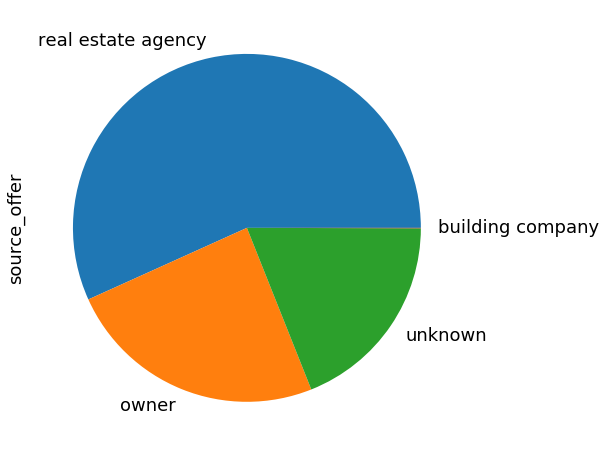

In [114]:
df_partial = df['source_offer'].value_counts()
chart = df_partial.plot.pie(figsize=(8, 8))

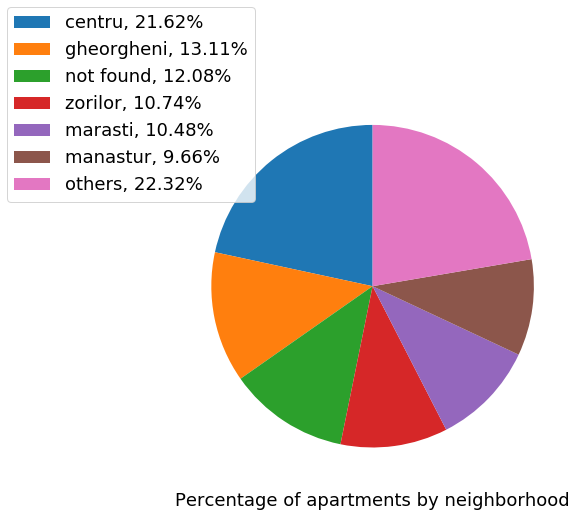

In [132]:
neighborhood_chart = build_piechart(
    df, 'neighborhood', 6, 'Percentage of apartments by neighborhood'
)

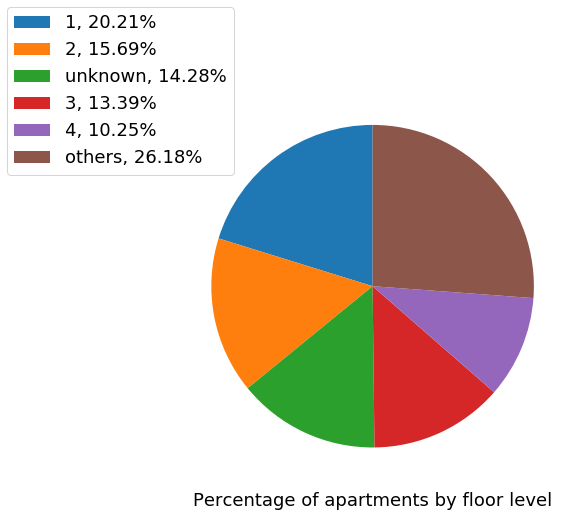

In [133]:
floors_chart = build_piechart(
    df, 'floor', 5, 'Percentage of apartments by floor level'
)

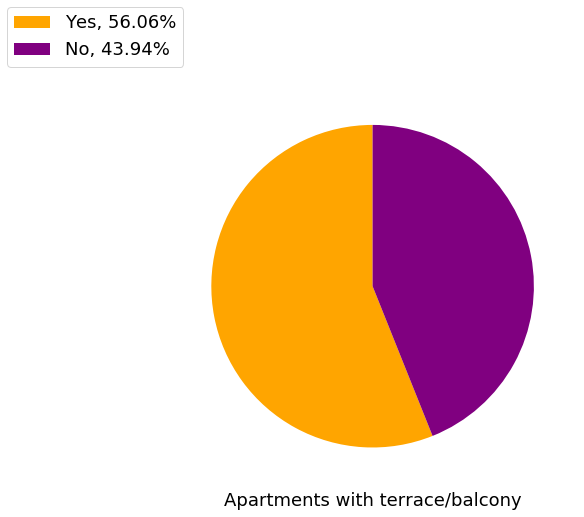

In [135]:
chart_terrace = build_piechart(
    df, 'terrace', title='Apartments with terrace/balcony', yesno=True
)

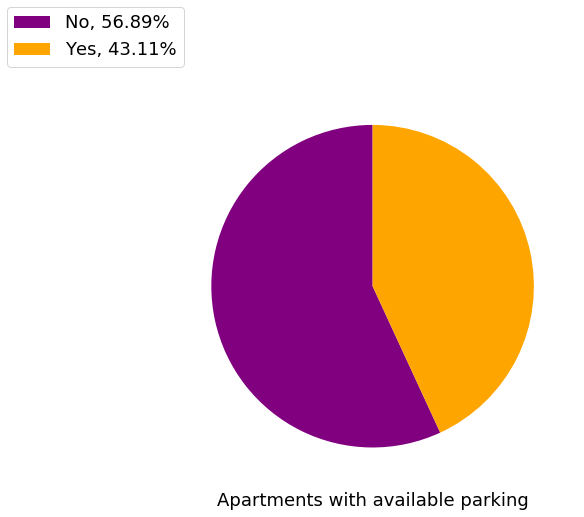

In [137]:
chart_parking = build_piechart(
    df, 'parking', title='Apartments with available parking', yesno=True
)

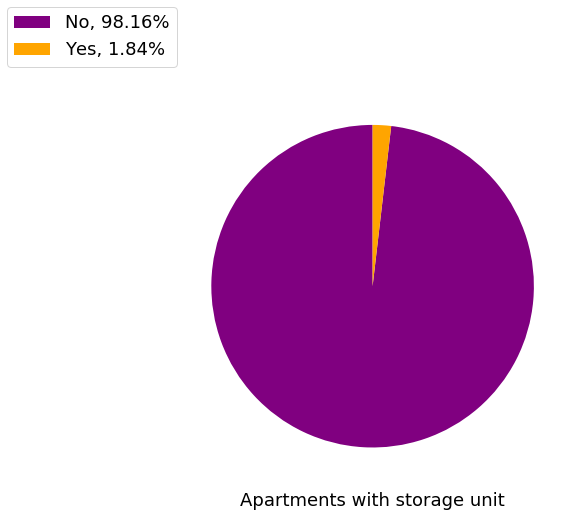

In [138]:
chart_storage = build_piechart(
    df, 'cellar', title='Apartments with storage unit', yesno=True
)

<a href="https://danielacraciun.github.io/apartment-hunter/#jump-back">Return to presentation</a>

Now, let's starting looking for apartments! This is automated, too.

In [142]:
# How many other apartments like this one?
df_similar_ap = df_3rooms_myarea[
    (df_3rooms_myarea['price']<=450) & 
    (df_3rooms_myarea['surface']>60) & 
    (df_3rooms_myarea['surface']<70)
]
percentage = (df_similar_ap.shape[0] - 1)/df.shape[0] * 100
print(f"There's other {percentage:.3f}% similar apartments (around {df_similar_ap.shape[0]})")

There's other 0.137% similar apartments (around 15)
